In [7]:
!pip install -q kaggle
from google.colab import files
files.upload()
 

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"sneakysnake","key":"e93c3c7a3fd26c7cc2884f0cad1a61f7"}'}

In [11]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [12]:
!kaggle datasets download -d sneakysnake/dmtm-dataset
!mkdir dmtm-dataset
!unzip dmtm-dataset.zip -d dmtm-dataset

 75% 48.0M/64.3M [00:02<00:01, 11.4MB/s]
100% 64.3M/64.3M [00:02<00:00, 26.8MB/s]
mkdir: cannot create directory ‘dmtm-dataset’: File exists
Archive:  dmtm-dataset.zip
  inflating: dmtm-dataset/submission.csv  
  inflating: dmtm-dataset/test.csv   
  inflating: dmtm-dataset/train.csv  


In [13]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from numpy import argmax


import warnings
warnings.filterwarnings('ignore')


In [14]:
import pandas as pd
import datetime as dt
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler



class data_container:
    """container class for a dataset"""

    def __init__(self, dataset, drop=True):

        self._dataset = dataset

        df = self._dataset.copy()

        df['DATE'] = pd.to_datetime(df['DATE'])

        weather_names = ['_temperature_', '_rain_mm_', '_humidity_', '_wind_speed_', '_pressure_']

        for name in weather_names:
            df['max' + name + 'prev14d'] = df['max' + name + 'prev7d']
            df['max' + name + 'prev7d_shift'] = df['max' + name + 'prev7d'].shift(7, axis=0)
            df.loc[df.DATE > '2019-04-16', 'max' + name + 'prev14d'] = df[df['DATE'] > '2019-04-16'][
                ['max' + name + 'prev7d', 'max' + name + 'prev7d_shift']].max(axis=1)
            df = df.drop(columns=['max' + name + 'prev7d_shift'])

            df['min' + name + 'prev14d'] = df['min' + name + 'prev7d']
            df['min' + name + 'prev7d_shift'] = df['min' + name + 'prev7d'].shift(7, axis=0)
            df.loc[df.DATE > '2019-04-16', 'min' + name + 'prev14d'] = df[df['DATE'] > '2019-04-16'][
                ['min' + name + 'prev7d', 'min' + name + 'prev7d_shift']].min(axis=1)
            df = df.drop(columns=['min' + name + 'prev7d_shift'])

            df['mean' + name + 'prev14d'] = df['mean' + name + 'prev7d']
            df['mean' + name + 'prev7d_shift'] = df['mean' + name + 'prev7d'].shift(7, axis=0)
            df.loc[df.DATE > '2019-04-16', 'mean' + name + 'prev14d'] = df[df['DATE'] > '2019-04-16'][
                ['mean' + name + 'prev7d', 'mean' + name + 'prev7d_shift']].mean(axis=1)
            df = df.drop(columns=['mean' + name + 'prev7d_shift'])

        persistance_names = ['equipment', 'fire/smoke', 'ge', 'power', 'temperature']

        for name in persistance_names:
            df[name + '_max_persistance_prev14d'] = df[name + '_max_persistance_prev7d']
            df[name + '_max_persistance_prev7d_shift'] = df[name + '_max_persistance_prev7d'].shift(7, axis=0)
            df.loc[df.DATE > '2019-04-16', name + '_max_persistance_prev14d'] = df[df['DATE'] > '2019-04-16'][
                [name + '_max_persistance_prev7d', name + '_max_persistance_prev7d_shift']].max(axis=1)
            df = df.drop(columns=[name + '_max_persistance_prev7d_shift'])

            df[name + '_min_persistance_prev14d'] = df[name + '_min_persistance_prev7d']
            df[name + '_min_persistance_prev7d_shift'] = df[name + '_min_persistance_prev7d'].shift(7, axis=0)
            df.loc[df.DATE > '2019-04-16', name + '_min_persistance_prev14d'] = df[df['DATE'] > '2019-04-16'][
                [name + '_min_persistance_prev7d', name + '_min_persistance_prev7d_shift']].min(axis=1)
            df = df.drop(columns=[name + '_min_persistance_prev7d_shift'])

            df[name + '_mean_persistance_prev14d'] = df[name + '_mean_persistance_prev7d']
            df[name + '_mean_persistance_prev7d_shift'] = df[name + '_mean_persistance_prev7d'].shift(7, axis=0)
            df.loc[df.DATE > '2019-04-16', name + '_mean_persistance_prev14d'] = df[df['DATE'] > '2019-04-16'][
                [name + '_mean_persistance_prev7d', name + '_mean_persistance_prev7d_shift']].mean(axis=1)
            df = df.drop(columns=[name + '_mean_persistance_prev7d_shift'])

        self._temperature_cols = [col for col in df.columns if 'temperature' in col]
        self._humidity_cols = [col for col in df.columns if 'humidity' in col]
        self._wind_cols = [col for col in df.columns if 'wind' in col]
        self._rain_cols = [col for col in df.columns if 'rain' in col]
        self._alarm_cols = [col for col in df.columns if 'alarm' in col]
        self._pressure_cols = [col for col in df.columns if 'pressure' in col]
        self._persistance_cols = [col for col in df.columns if 'persistance' in col]
        self._aircon_cols = [col for col in df.columns if 'wo_prev' in col]

        self._numerical_features = self._temperature_cols + self._humidity_cols + \
                                   self._wind_cols + self._rain_cols + self._alarm_cols + \
                                   self._pressure_cols + self._persistance_cols + self._aircon_cols
        
        
        
        # process data feature
        df['month'] = df['DATE'].dt.month
        df['day'] = df['DATE'].dt.day
        df['year'] = df['DATE'].dt.year % 2019
        df['day' + '_sin'] = np.sin(2 * np.pi * df['day']/df['day'].max())
        df['day' + '_cos'] = np.cos(2 * np.pi * df['day']/df['day'].max())
        
        cell_type = [col for col in df.columns if 'CELL_TYPE' in col]
        df = df.drop(columns=cell_type)
        df = df.drop(columns='day')
        
        if drop == True:
            # drop unused columns
            df = df.drop(columns=['DATE', 'SITE_ID'])
        
        self._prepared_dataset = df
            
    @property
    def prepared_dataset(self):
        """returns a copy of the dataset ready to be passed to the model"""
        return self._prepared_dataset

    @property
    def dataset(self):
        return self._dataset

    @property
    def numerical_features(self):
        return self._numerical_features

    def features_by_type(self, features=None, dataset_type='prepared'):
        """returns a DataFrame with the selected features (temperature, humidity, wind, rain)"""
        if features == None:
            return None

        elif features in ['temperature', 'humidity', 'wind', 'rain', 'pressure']:
            cols = [i for i in self.dataset.columns if features in i]

            if dataset_type == 'prepared':
                return self.prepared_dataset[cols]

            elif dataset_type == 'raw':
                return self.dataset[cols]

        return None

    def run_PCA(self, features=None, components=12, append=False):
        """run PCA on the requested normalized features features (temperature, humidity, wind, rain) with the requested number of components, returns the principals components and the explained variance"""
        normalized_features = self.features_by_type(features)

        pca = PCA(n_components=components)
        pca.fit(normalized_features)
        PCA_components = pca.transform(normalized_features)
        explained_variance = pca.explained_variance_ratio_

        if append == True:
            columns = [features + '_pca_%i' % i for i in range(components)]
            print(columns)
            to_drop = [i for i in self.dataset.columns if features in i]
            self._prepared_dataset = self._prepared_dataset.drop(columns=to_drop)
            print(columns)

            self._prepared_dataset[columns] = PCA_components
            print(self._prepared_dataset[columns].shape)
        return PCA_components, explained_variance

    def normalize_dataset(self):
        scaler = StandardScaler()
        features = self.numerical_features
        scaler.fit(self.prepared_dataset[features])
        normalized_features = scaler.transform(self.prepared_dataset[features])
        self.prepared_dataset[features] = normalized_features
        return self.prepared_dataset

    def compute_14d_features(self):
        df_14d = self.prepared_dataset[
            [col for col in self.prepared_dataset.columns if '3d' not in col and '7d' not in col]]
        return df_14d




In [15]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(15,25))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    

def plot_roc_curve(y, predictions, ax):
    fpr, tpr, thresholds = roc_curve(y, predictions)
    ax.plot([0,1], [0,1], linestyle='--', label='xgboost')
    ax.plot(fpr, tpr, marker='.', label='Logistic')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend()
    ax.plot()

def plot_precision_recall_curve(y, predictions, ax):
    precision, recall, thresholds = precision_recall_curve(y, predictions)
    no_skill = len(y[y==1]) / len(y)
    ax.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
    ax.plot(recall, precision, marker='.', label='xgboost')
    ax.set_xlabel('recall')
    ax.set_ylabel('precision')
    ax.legend()
    ax.plot()

def cyclical_encoding(df, col, max_val):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col]/max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col]/max_val)
    return df
    
rectifier = lambda x, thr: 0 if x < thr else 1

In [55]:
#to drop after ttest 
cols = ['max_temperature_f_next14d',
        'min_temperature_f_next14d',
        'max_temperature_prev14d',
        'min_temperature_prev14d',
        'mean_temperature_prev14d',
        'max_humidity_f_next14d',
        'min_humidity_f_next14d',
        'mean_humidity_prev14d',
        'max_wind_speed_f_next14d',
        'mean_wind_speed_prev14d',
        'skew_equipment_alarms_prev14d', 'skew_fire/smoke_alarms_prev14d',
        'skew_ge_alarms_prev14d', 'skew_power_alarms_prev14d',
        'skew_temperature_alarms_prev14d', 'kurt_equipment_alarms_prev14d',
        'kurt_fire/smoke_alarms_prev14d', 'kurt_ge_alarms_prev14d',
        'kurt_power_alarms_prev14d', 'kurt_temperature_alarms_prev14d',
        ]



In [17]:
train = pd.read_csv('dmtm-dataset/train.csv')
container = data_container(train, drop=False)

In [84]:

np.random.seed(42)
train_df = container.prepared_dataset
train_df_14d = container.compute_14d_features()
train_df = train_df_14d

SITE_ID  = train_df['SITE_ID'].unique()

np.random.shuffle(SITE_ID)
oldout_ID = [x for x in SITE_ID if np.random.uniform(0, 1) < 0.2]



In [85]:


next_cols = [col for col in train_df.columns if ('next' in col and not 'aircon' in col)]
cols = cols + next_cols + ['aircon_sum_wo_prev14d']


train_df = train_df.drop(columns=cols)
oldout_set =  train_df[train_df['SITE_ID'].isin(oldout_ID)]
print(len(oldout_set['SITE_ID'].unique()))

train_df = train_df[~train_df['SITE_ID'].isin(oldout_ID)]
print(len(train_df['SITE_ID'].unique()))

403
1668


In [86]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42, sampling_strategy=0.1)

y_train = train_df['aircon_sum_target_next14d']
X_train = train_df.drop(columns=['SITE_ID', 'DATE', 'aircon_sum_target_next14d'])
y_test = oldout_set['aircon_sum_target_next14d']
X_test = oldout_set.drop(columns=['aircon_sum_target_next14d', 'DATE', 'SITE_ID'])

X_res, y_res = rus.fit_resample(X_train, y_train)

In [87]:
X_train = pd.DataFrame(X_res, columns=X_train.columns)
y_train = y_res

In [88]:
params = {'tree_method': 'gpu_hist',
          'verbosity': 3,
          'objective':'binary:logistic',
          'subsample' : 0.6,
          'min_child_weight' : 1,
          "colsample_bytree": 0.8,
          'learning_rate': 0.2, 
          'alpha': 1,
          'scale_pos_weight' : 100,
          'gamma' : 0,
          'predictor' : 'gpu_predictor',
          'max_depth' : 5, #4
          'n_estimators' : 1500, #4
           }


model = xgb.XGBClassifier(**params)
 

In [95]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60543, 44)
(60543,)
(120900, 44)
(120900,)


In [89]:
model.fit(X_train, y_train, verbose=True, eval_metric='logloss',eval_set=[(X_test, y_test)], early_stopping_rounds= 200)

[0]	validation_0-logloss:0.792853
Will train until validation_0-logloss hasn't improved in 200 rounds.
[1]	validation_0-logloss:0.898381
[2]	validation_0-logloss:0.992341
[3]	validation_0-logloss:1.0639
[4]	validation_0-logloss:1.11761
[5]	validation_0-logloss:1.16535
[6]	validation_0-logloss:1.20732
[7]	validation_0-logloss:1.23799
[8]	validation_0-logloss:1.27056
[9]	validation_0-logloss:1.29417
[10]	validation_0-logloss:1.31258
[11]	validation_0-logloss:1.32017
[12]	validation_0-logloss:1.30891
[13]	validation_0-logloss:1.30723
[14]	validation_0-logloss:1.29908
[15]	validation_0-logloss:1.28673
[16]	validation_0-logloss:1.27116
[17]	validation_0-logloss:1.26112
[18]	validation_0-logloss:1.23997
[19]	validation_0-logloss:1.2292
[20]	validation_0-logloss:1.21546
[21]	validation_0-logloss:1.18141
[22]	validation_0-logloss:1.16582
[23]	validation_0-logloss:1.14956
[24]	validation_0-logloss:1.14195
[25]	validation_0-logloss:1.12168
[26]	validation_0-logloss:1.10897
[27]	validation_0-logl

XGBClassifier(alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=1500, n_jobs=1,
              nthread=None, objective='binary:logistic',
              predictor='gpu_predictor', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=100, seed=None, silent=None,
              subsample=0.6, tree_method='gpu_hist', verbosity=3)

In [90]:

test_predictions = model.predict_proba(X_test)[:, 1]

f1 score:  0.07551020408163266
precision:  0.13214285714285715
recall: 0.05285714285714286
auc precision-recall:  0.030294711105072678


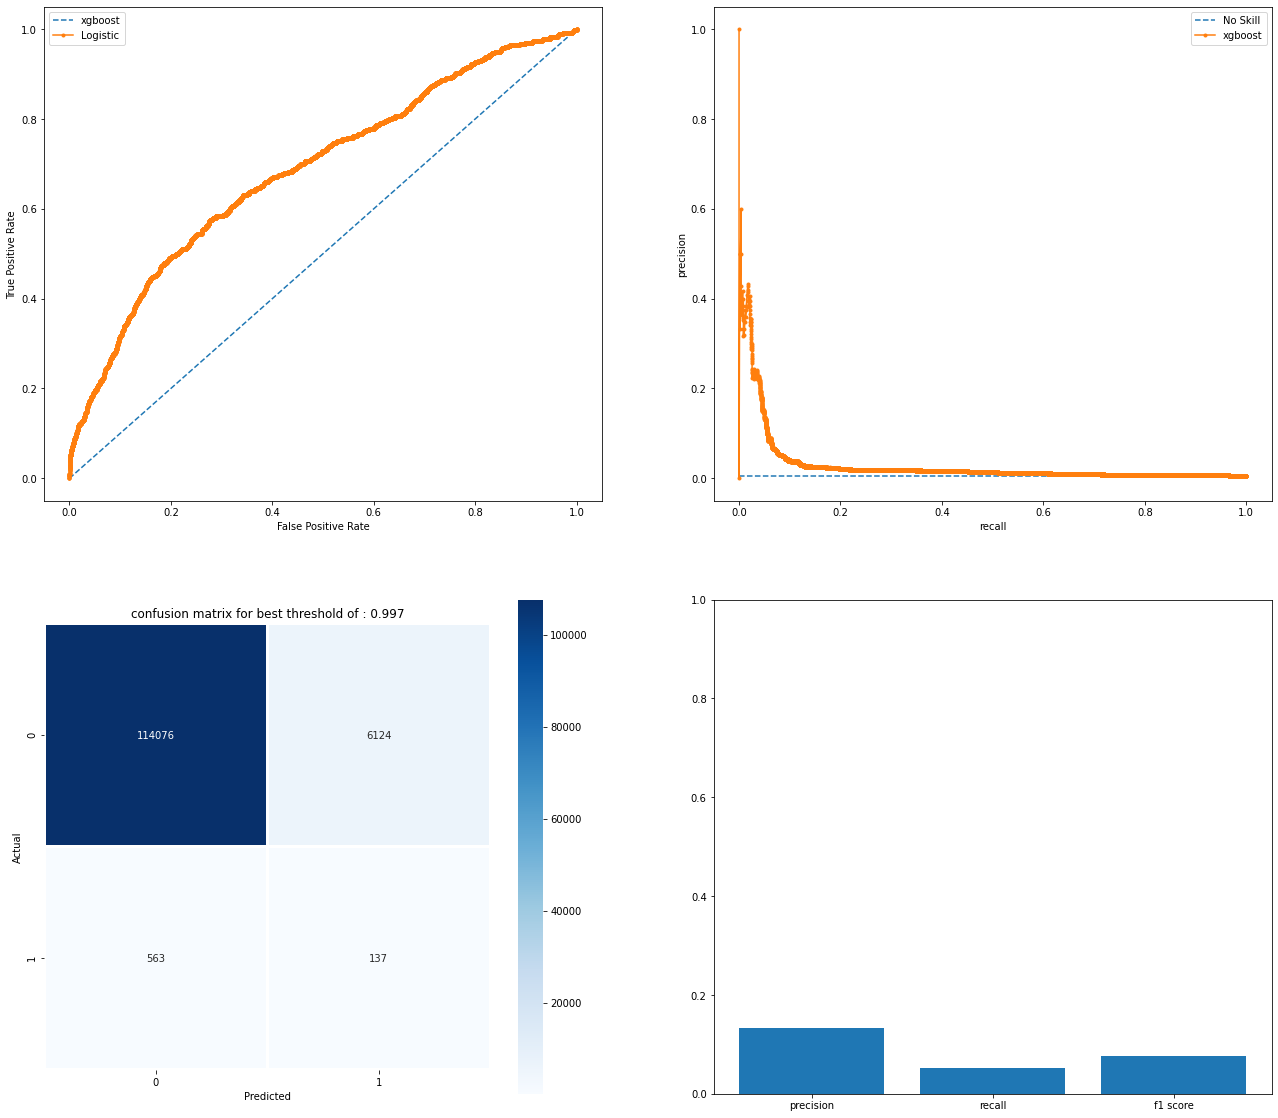

In [91]:
from matplotlib import pyplot as plt

f, axs = f, axs = plt.subplots(figsize= (22,20), ncols=2, nrows=2)
plot_roc_curve(y_test, test_predictions, axs[0][0])
precision, recall, thresholds = precision_recall_curve(y_test, test_predictions)
plot_precision_recall_curve(y_test, test_predictions, axs[0][1])


fscore = (2 * precision * recall) / (precision + recall)
fscore = fscore[~np.isnan(fscore)]
ix = argmax(fscore)
max_fscore = fscore[ix]
best_thr = thresholds[ix]
rectified = np.array([rectifier(x, 0.3) for x in test_predictions])


confusion_matrix = pd.crosstab(y_test.values, rectified, rownames=['Actual'], colnames=['Predicted'])
heatmap_title = 'confusion matrix for best threshold of : {thr:.3f}'
sns.heatmap(confusion_matrix, annot=True, fmt='d', square=True, cmap='Blues',
            ax=axs[1][0], robust=True, linewidth=2).set(title=heatmap_title.format(thr = best_thr));


max_precision = precision[ix]
max_recall = recall[ix]

x_bar = np.arange(3)
y_bar = np.array([max_precision, max_recall, max_fscore])
axs[1,1].set_ylim(0, 1)
axs[1,1].bar(x_bar, y_bar)
axs[1,1].set_xticks([0, 1, 2])
axs[1,1].set_xticklabels(['precision', 'recall', 'f1 score']);


print('f1 score: ', max_fscore)
print('precision: ', max_precision)
print('recall:', max_recall)
print('auc precision-recall: ', auc(recall, precision))

In [97]:



oldout_set['prediction'] = test_predictions
recalls = []

for date, daily_df in oldout_set.groupby(['DATE']):
    daily_df=daily_df.copy()
    daily_df['final_prediction'] = 0
    daily_df['NORM_N_TRANSPORTED_SITES' ] = daily_df['N_TRANSPORTED_SITES' ]/daily_df['N_TRANSPORTED_SITES'].max()
    daily_df['weighted_prediction' ] = 0.8* daily_df['prediction' ] + 0.2*daily_df['NORM_N_TRANSPORTED_SITES']
    daily_df = daily_df.sort_values(by=['weighted_prediction' ], ascending=False)
    daily_df = daily_df.reset_index(drop=True)
    daily_df.loc[0:10, 'final_prediction' ] = 1
    daily_recall = recall_score(y_true=daily_df['aircon_sum_target_next14d' ], y_pred=daily_df['final_prediction' ])
    recalls.append(daily_recall)
final_metric= np.mean(recalls)
print(final_metric)

0.10672222222222222


AttributeError: ignored

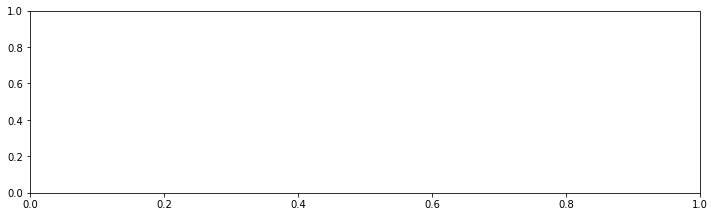

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,30*4))
import matplotlib.gridspec as gridspec
features = train_df.iloc[:,0:30].columns
gs = gridspec.GridSpec(30, 1)
for i, feature in enumerate(train_df[features]):
    ax = plt.subplot(gs[i])
    sns.distplot(train_df[feature][train_df.aircon_sum_target_next14d == 1], bins=50)
    sns.distplot(train_df[feature][train_df.aircon_sum_target_next14d == 0], bins=50)
    ax.set_xlabel('')
    ax.set_title('Feature: ' + str(feature))
plt.show()

In [122]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as k
import tensorflow.keras

nn_model = tf.keras.Sequential()

nn_model.add(Dense(44, activation='relu', input_shape=(44,)))
nn_model.add(Dense(88, activation='relu'))
nn_model.add(Dropout(0.3))
nn_model.add(Dense(1, activation='sigmoid'))


nn_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 44)                1980      
_________________________________________________________________
dense_14 (Dense)             (None, 88)                3960      
_________________________________________________________________
dropout_3 (Dropout)          (None, 88)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 89        
Total params: 6,029
Trainable params: 6,029
Non-trainable params: 0
_________________________________________________________________


In [137]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)


In [ ]:
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0
class_weight = {0: weight_for_0, 1: weight_for_1}



nn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.Recall()])

nn_model.fit(X_train, y_train, batch_size=128, epochs=100, validation_data=(X_test, y_test), class_weight=)

### Model with SITE_ID split